<img src='https://upload.wikimedia.org/wikipedia/commons/d/d8/Deerfire_high_res_edit.jpg' width='1200px'/>

In [1]:
target = 'area'

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV

# Load and describe data

In [3]:
# path = 'forestfires.csv'
path = "forestfires.csv"
df = pd.read_csv(path)

df.shape

(517, 13)

In [4]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


---

# Missing value treatment

In [6]:
df.isna().sum().sum()

0

---

# Exploratory Data Analysis
   We will try out the following analysis on our dataset
   - Univariate 
   - Bivariate 
   - Multivariate

In [7]:
plt.rcParams["figure.figsize"] = 9,5

---

## Univariate analysis



### Let's begin with the target variable, `Area`

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


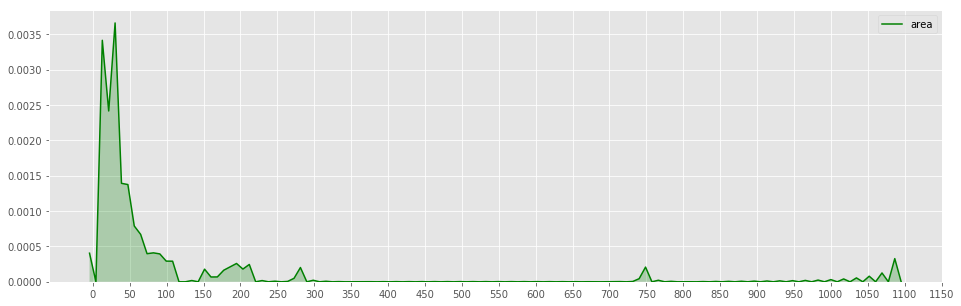

In [8]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

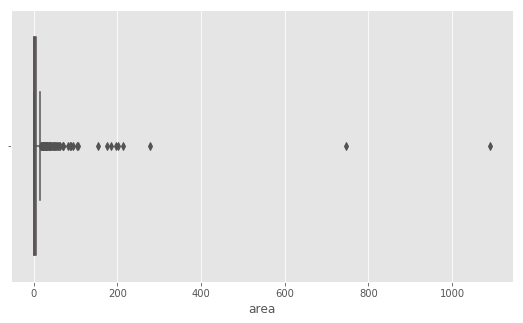

In [9]:
ax = sns.boxplot(df[target])

**Few observations:**

- The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

- It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

- We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

- Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [10]:
# Outlier points
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


### Independent columns 

In [11]:
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

### Categorical columns 

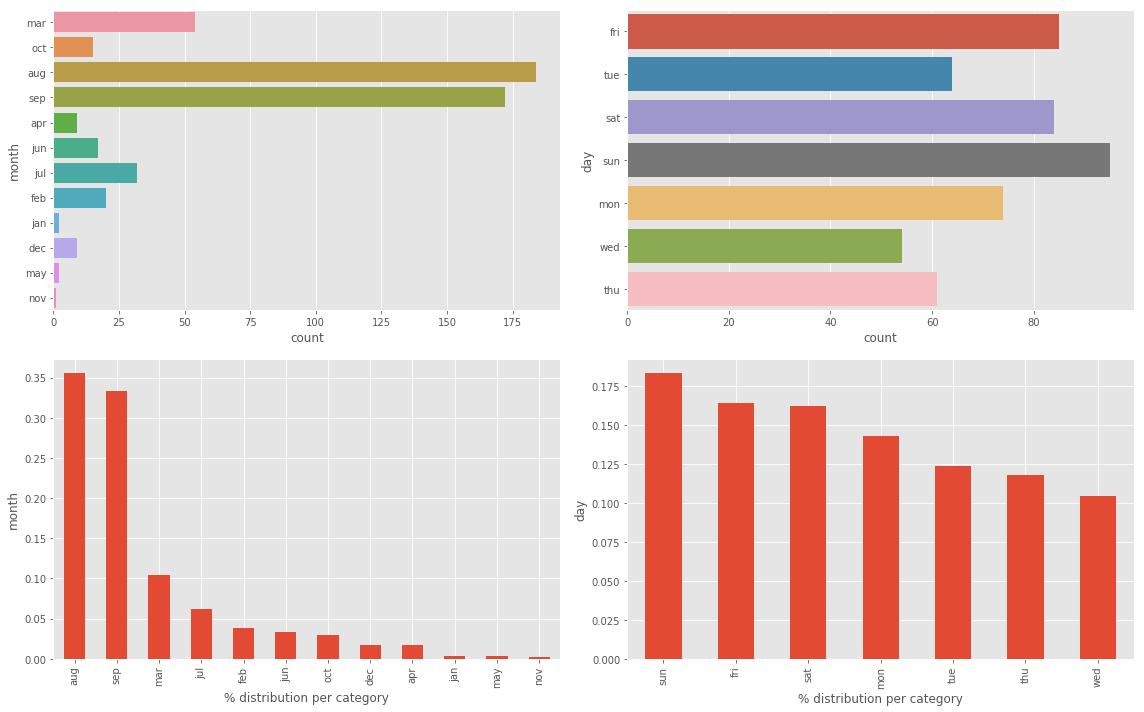

In [12]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()    

1. It is interesting to see that abnormally high number of the forest fires occur in the month of `August`
and `September`.

2. In the case of day, the days `Friday` to `Monday` have higher proportion of cases. (However, no strong indicators)

### Numerical Columns

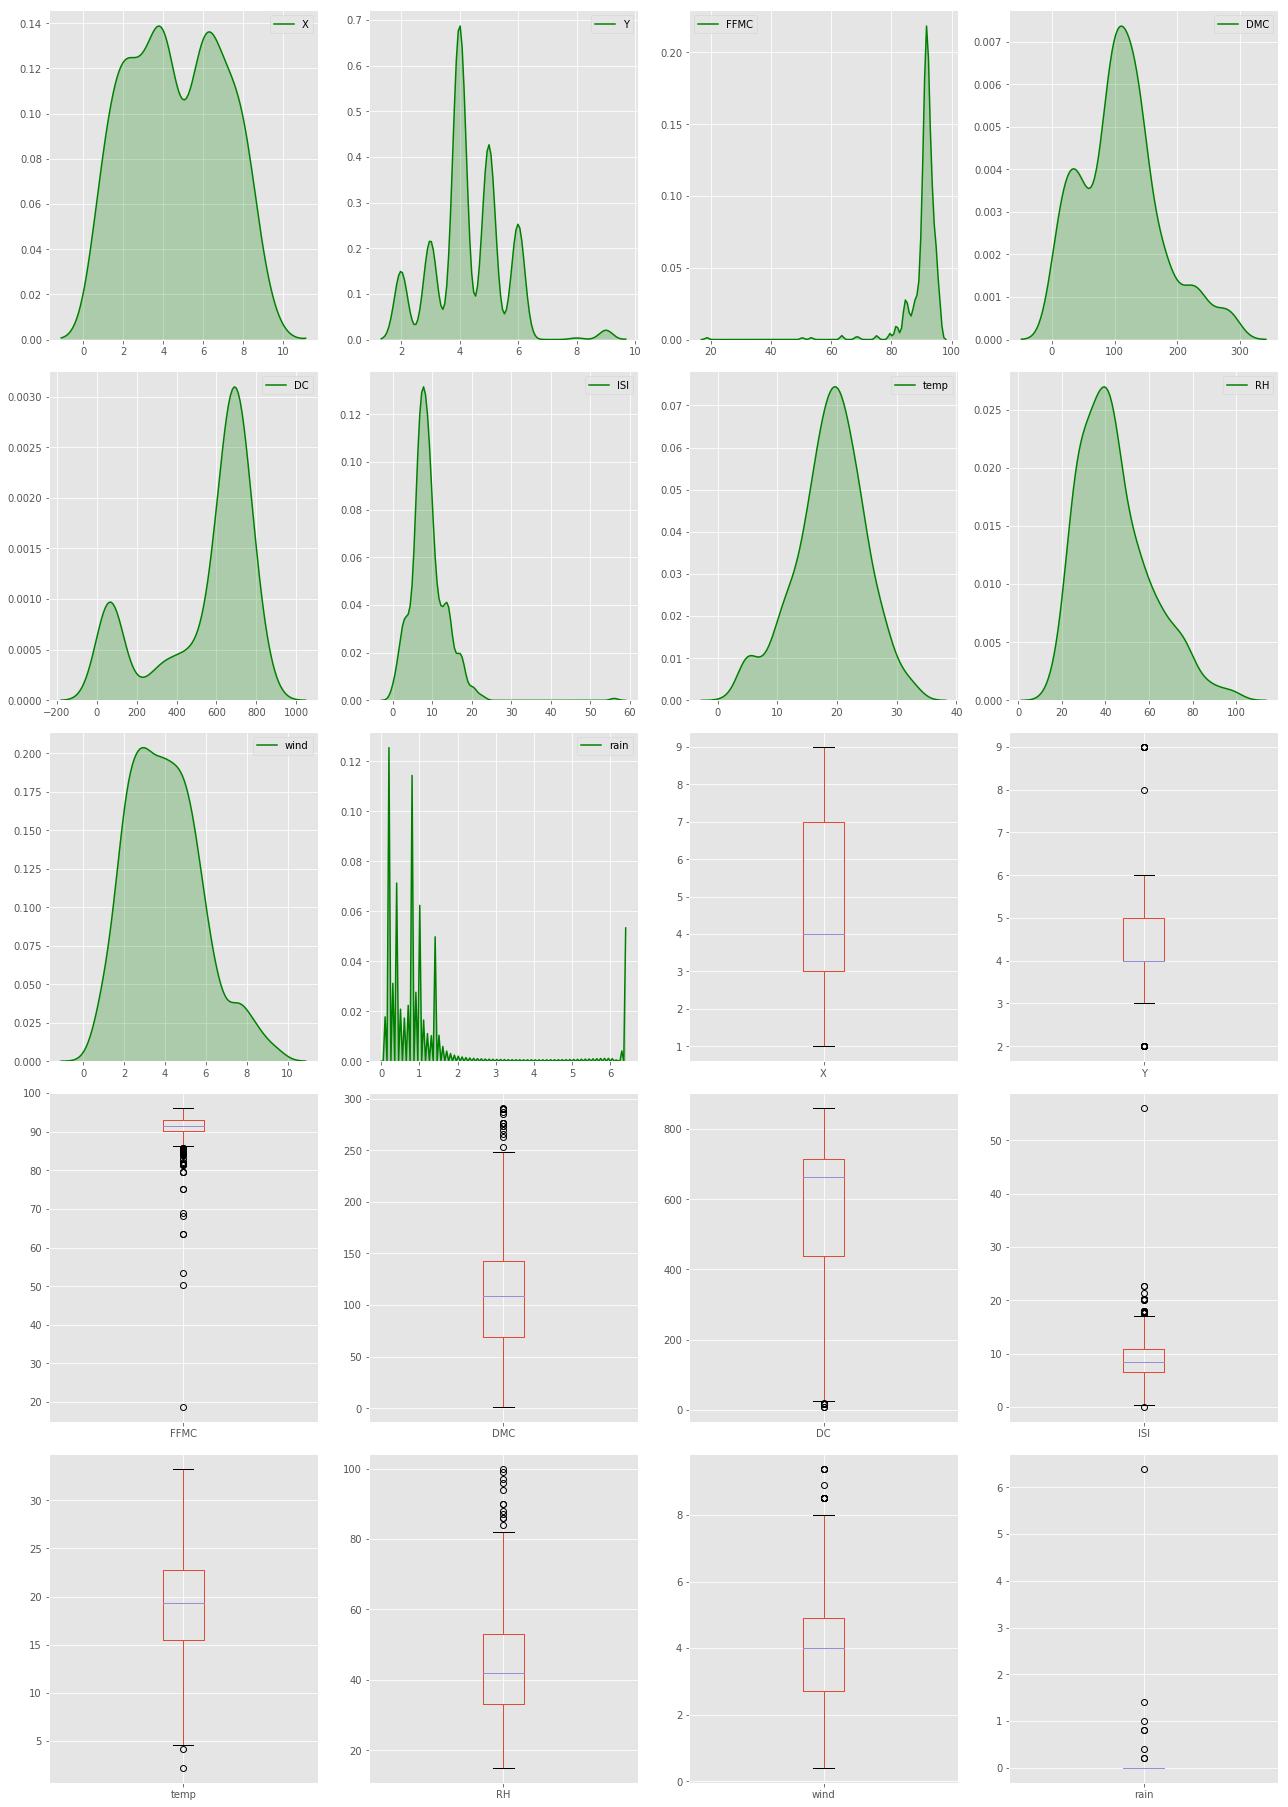

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [13]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

Outliers, Skewness and kurtosis (high positive or negative) was observed in the following columns:
1. FFMC
2. ISI
3. rain

---

## Bivariate analysis with our target variable

In [14]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [15]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


### Categorical columns

In [16]:
cat_columns

['month', 'day']

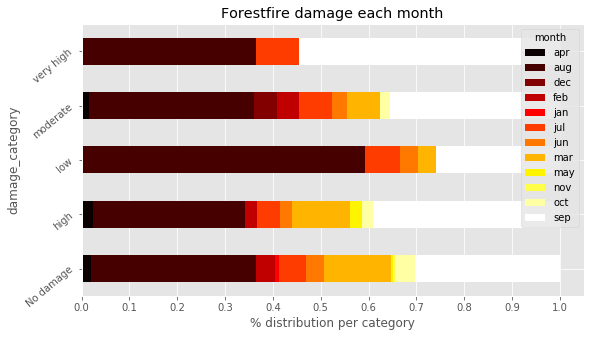

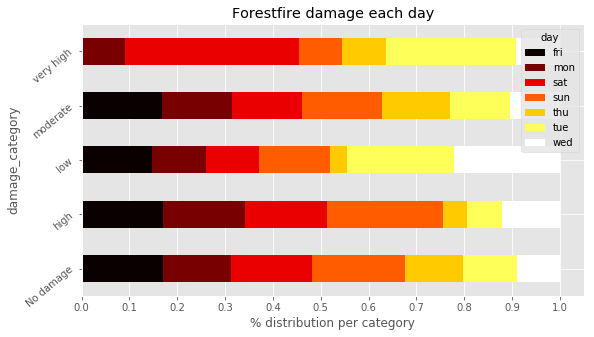

In [17]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

- Previously we had observed that `August` and `September` had the most number of forest fires. And from the above plot of `month`, we can understand few things
    - Most of the fires in August were low (< 1 hectare).
    - The very high damages(>100 hectares) happened in only 3 months - august,july and september.
 
- Regarding fire damage per day, nothing much can be observed. Except that, there were no ` very high` damaging fires on Friday and on Saturdays it has been reported most.

### Numerical columns

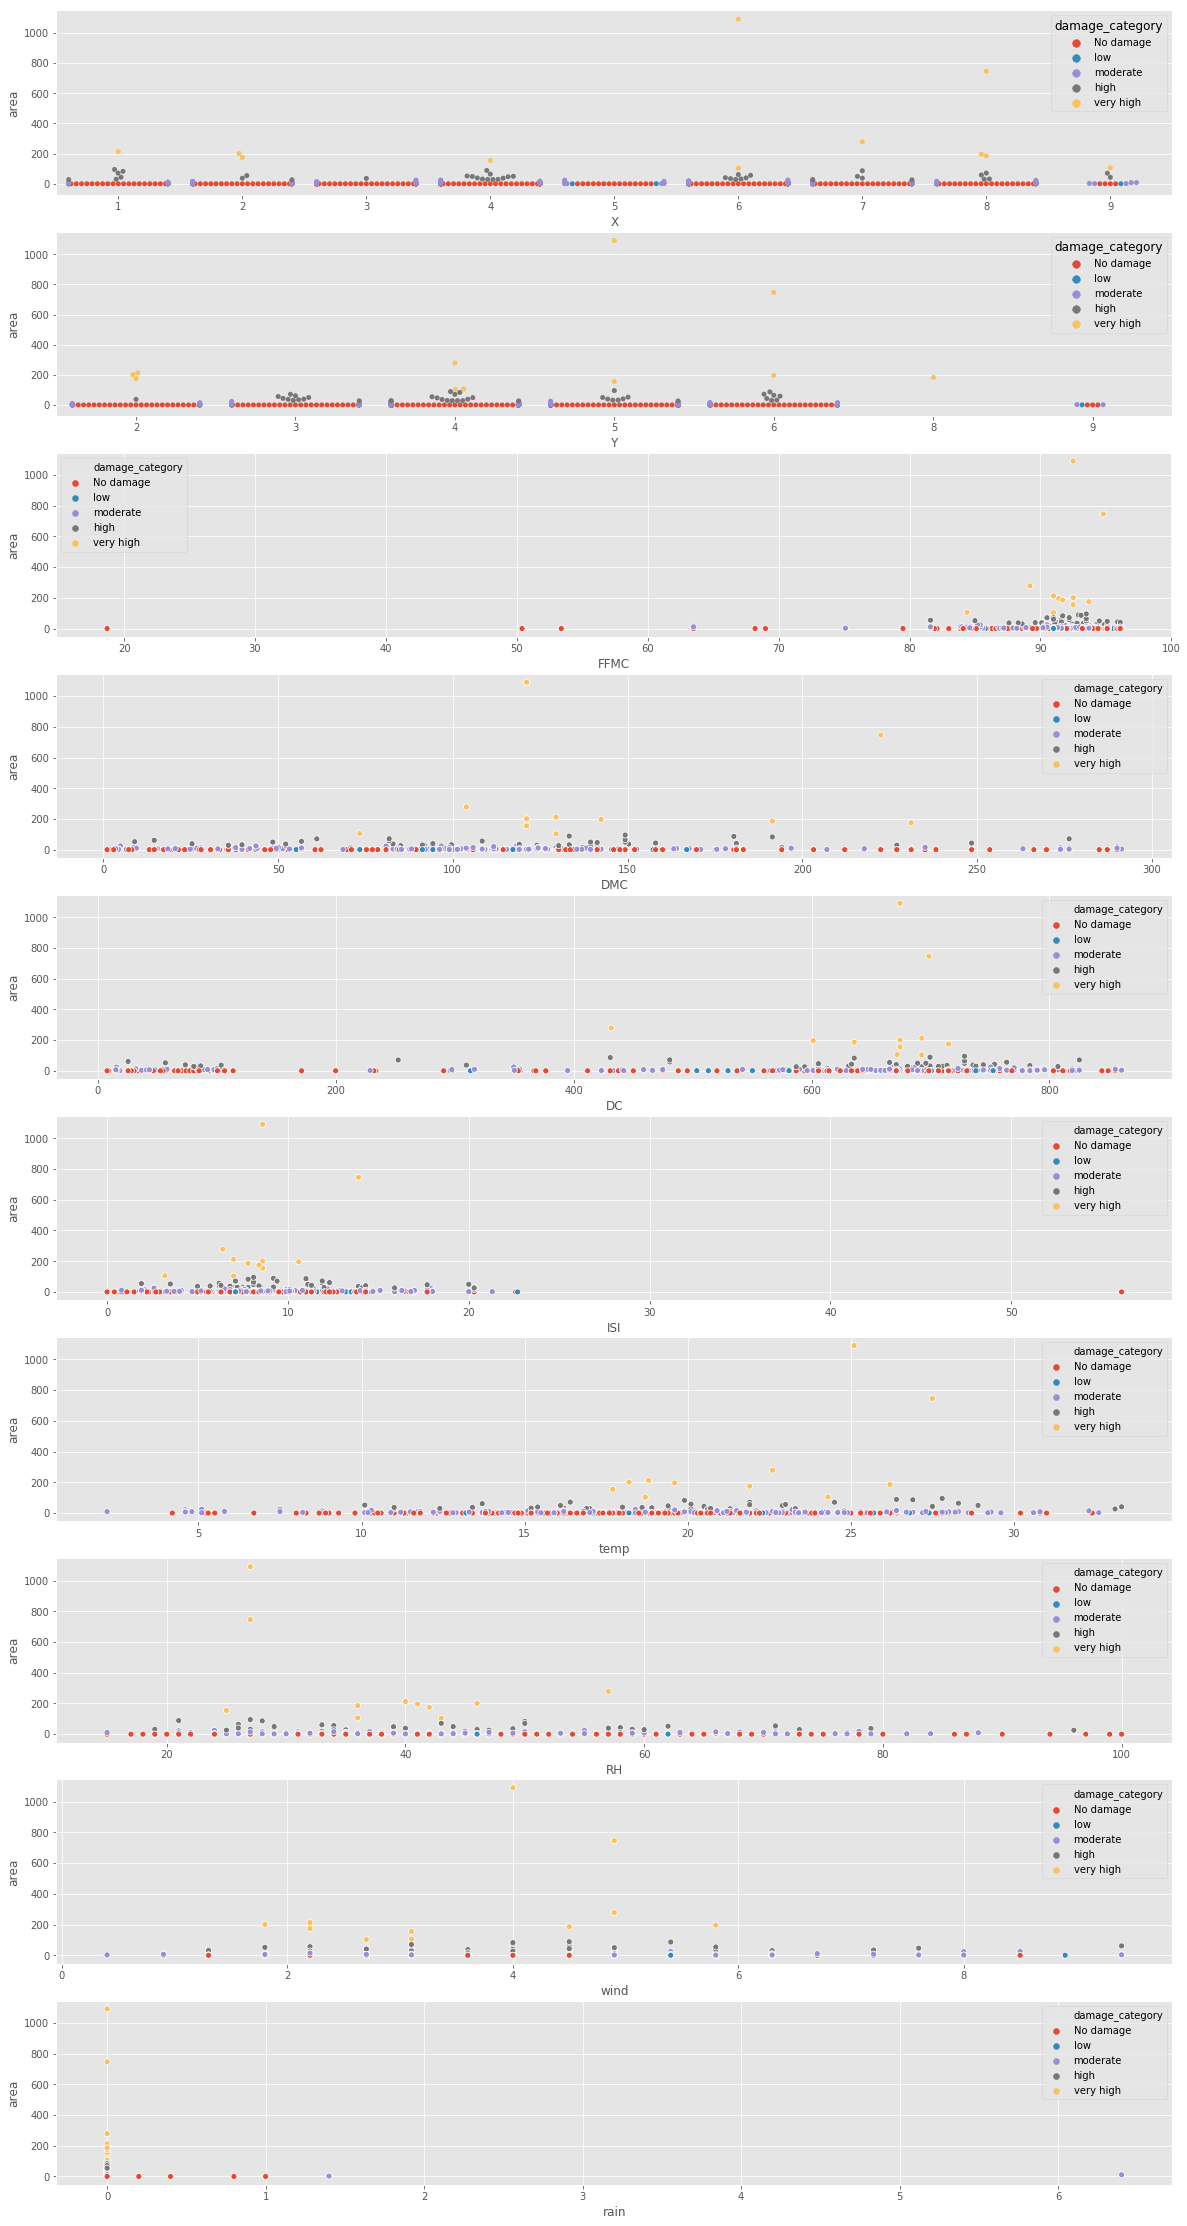

In [18]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y=target,hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

---

## Multivariate analysis

In [19]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


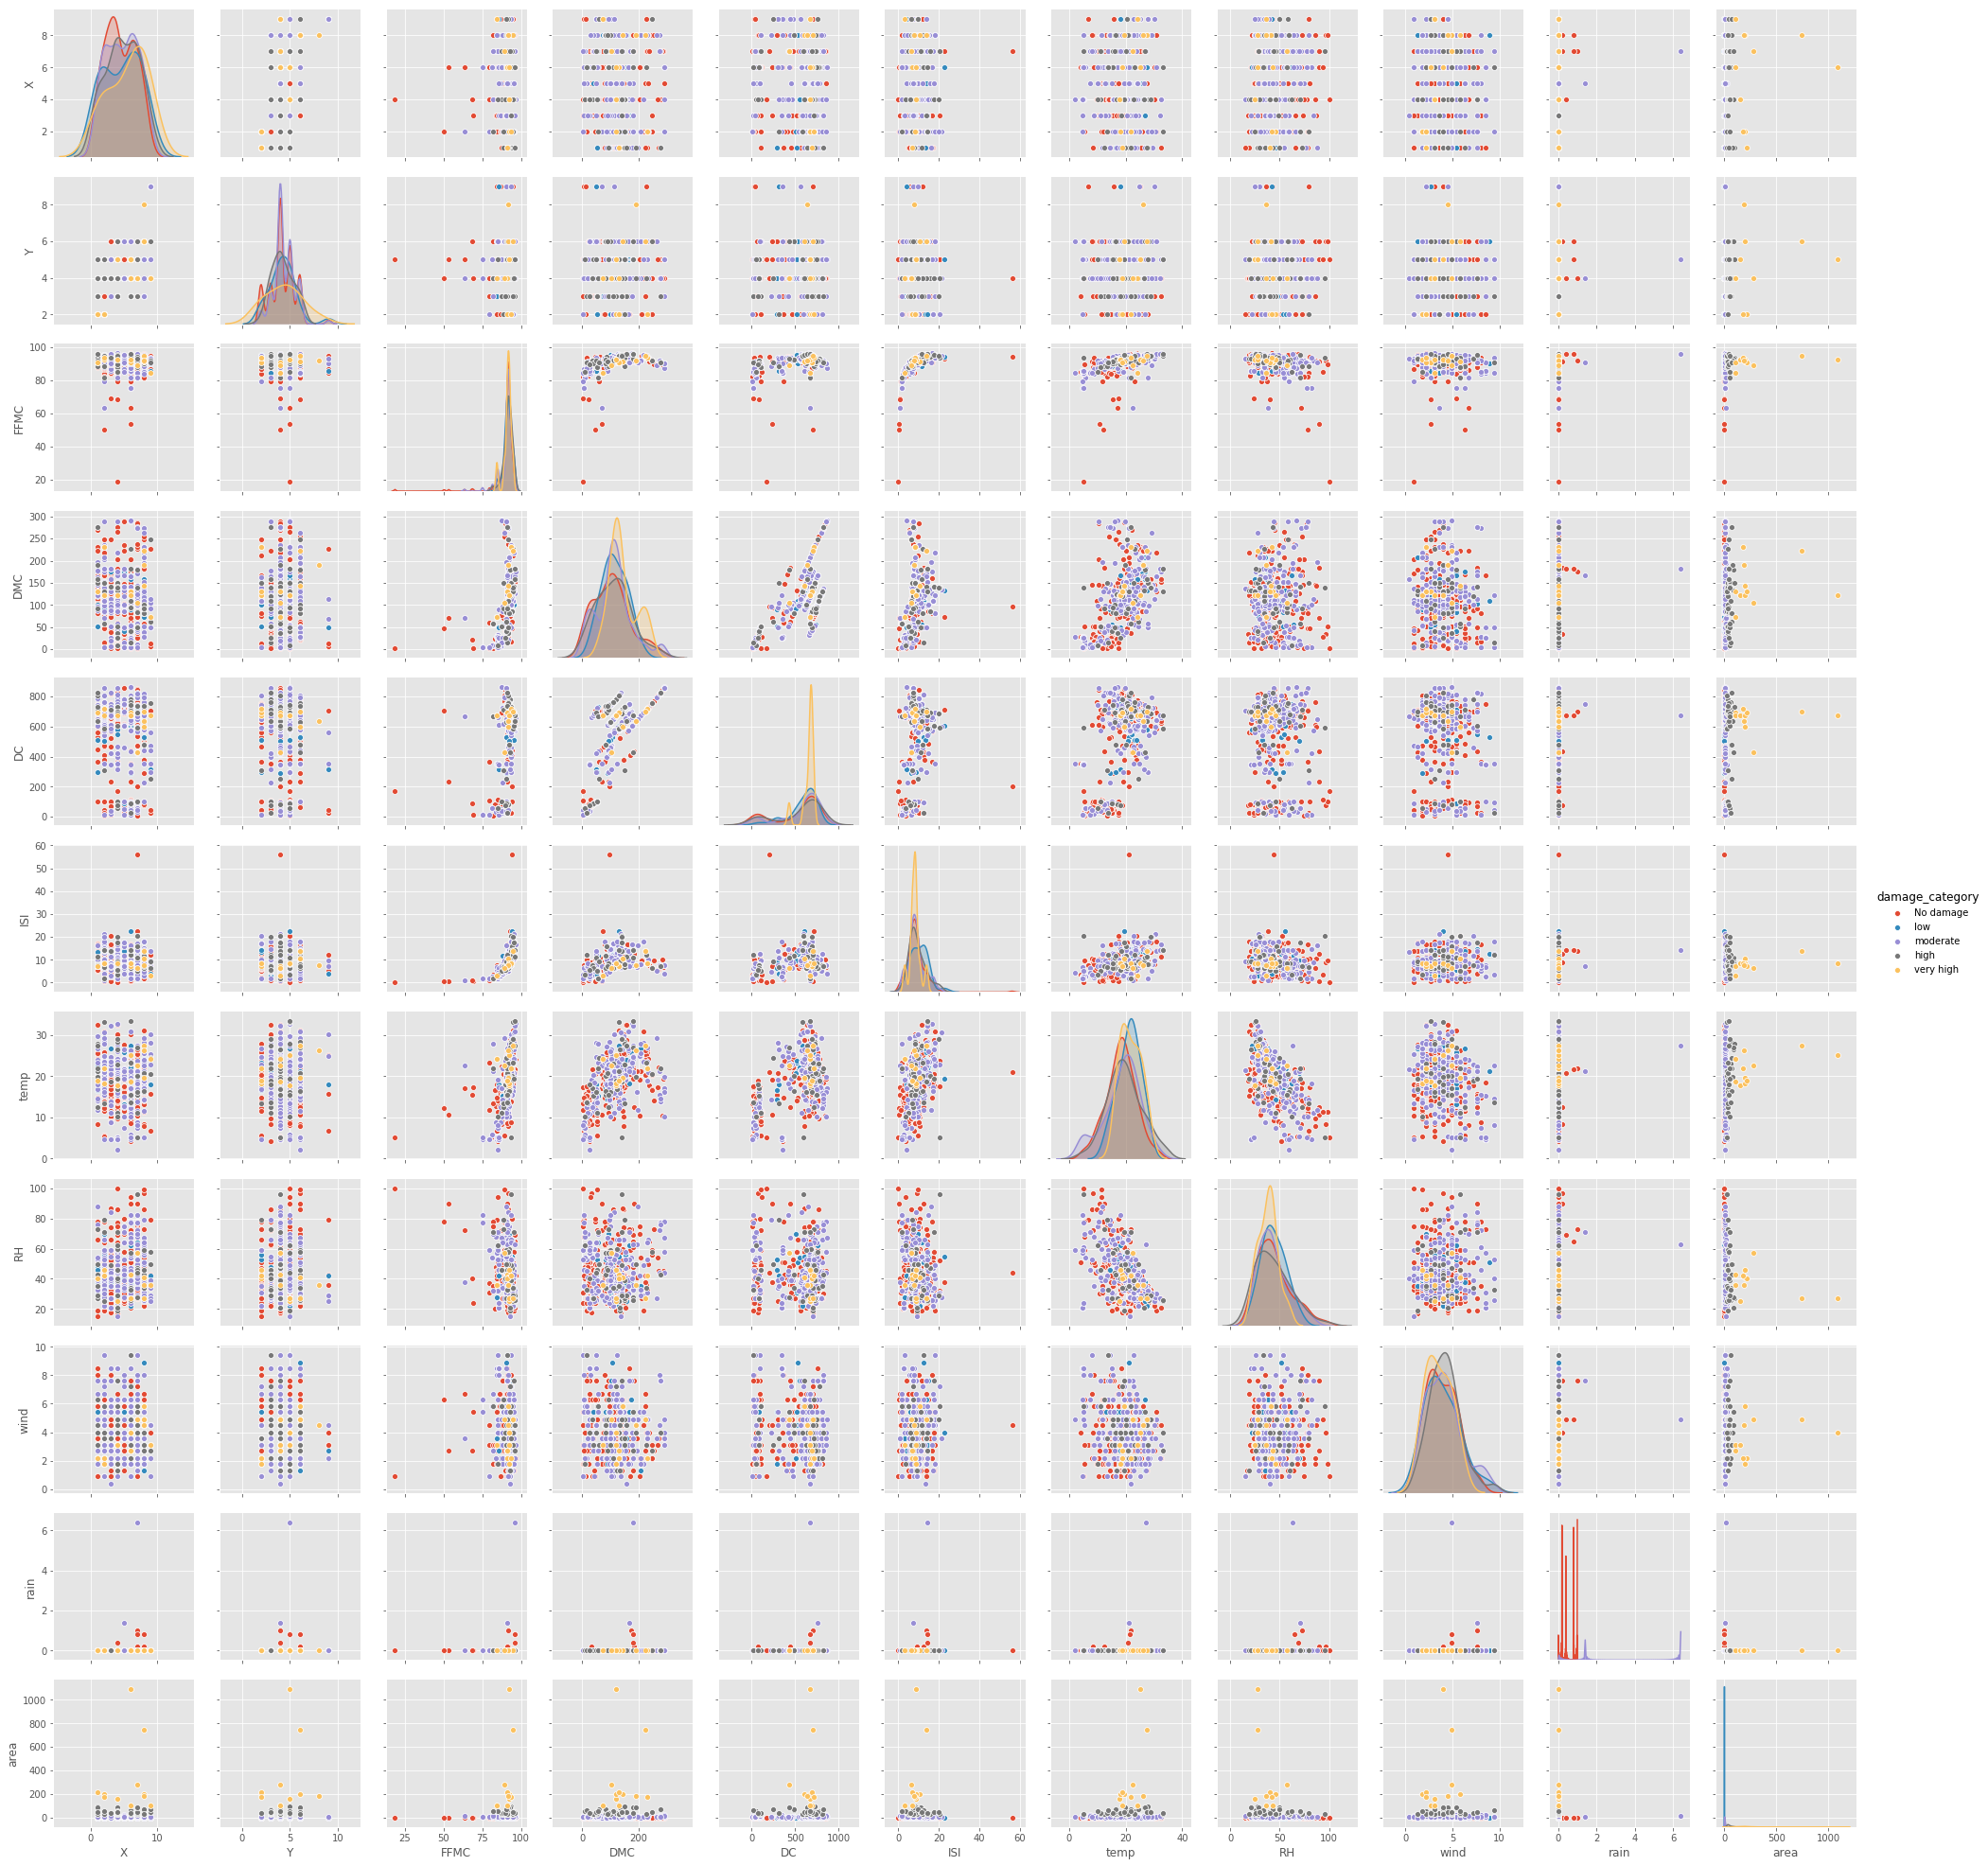

In [20]:
sns.pairplot(df,hue='damage_category',vars=selected_features)
plt.show()

---